<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%201/Case_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tabulate import tabulate

In [ ]:
df = pd.read_csv('train.csv') 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

In [ ]:
unique = pd.read_csv('unique_m.csv') 

In [ ]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   H              21263 non-null  float64
 1   He             21263 non-null  int64  
 2   Li             21263 non-null  float64
 3   Be             21263 non-null  float64
 4   B              21263 non-null  float64
 5   C              21263 non-null  float64
 6   N              21263 non-null  float64
 7   O              21263 non-null  float64
 8   F              21263 non-null  float64
 9   Ne             21263 non-null  int64  
 10  Na             21263 non-null  float64
 11  Mg             21263 non-null  float64
 12  Al             21263 non-null  float64
 13  Si             21263 non-null  float64
 14  P              21263 non-null  float64
 15  S              21263 non-null  float64
 16  Cl             21263 non-null  float64
 17  Ar             21263 non-null  int64  
 18  K     

In [12]:
# Make target and predictive datasets
y = df[['critical_temp']]
X = df.loc[:, df.columns != 'critical_temp']

In [30]:
Scaler = StandardScaler()
X_Scaled= Scaler.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns = X.columns)


In [31]:
lin_reg = LinearRegression()
# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []
MSE = []
RMSE = []
i=0
for train, test in cv.split(X_Scaled, y):

    X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    # Train the model
    lin_reg.fit(X_train, y_train)

    # Predict 
    y_pred_lin_reg = lin_reg.predict(X_test)


    # Calculate the mean absolute error, mean squared error, and root mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)
    lin_MSE_reg= metrics.mean_squared_error(y_test, y_pred_lin_reg)
    lin_RMSE_reg= metrics.mean_squared_error(y_test, y_pred_lin_reg)
    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)
    MSE.append(lin_MSE_reg)
    RMSE.append(lin_RMSE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, lin_MSE_reg, lin_RMSE_reg]], 
               headers=['Fold', 'MAE', 'RMSE']))

       Fold      MAE     RMSE
--  -------  -------  -------
 1  13.2415  295.999  295.999
       Fold     MAE    RMSE
--  -------  ------  ------
 2  13.1644  307.41  307.41
      Fold      MAE     RMSE
--  ------  -------  -------
 3  13.833  340.933  340.933
       Fold    MAE    RMSE
--  -------  -----  ------
 4  13.0929    296     296
       Fold      MAE     RMSE
--  -------  -------  -------
 5  13.5628  320.036  320.036
       Fold      MAE     RMSE
--  -------  -------  -------
 6  13.1817  302.314  302.314
       Fold     MAE    RMSE
--  -------  ------  ------
 7  13.4534  321.71  321.71
      Fold     MAE    RMSE
--  ------  ------  ------
 8  13.188  304.98  304.98
       Fold      MAE     RMSE
--  -------  -------  -------
 9  13.1779  305.989  305.989
      Fold      MAE     RMSE
--  ------  -------  -------
10  13.541  310.345  310.345


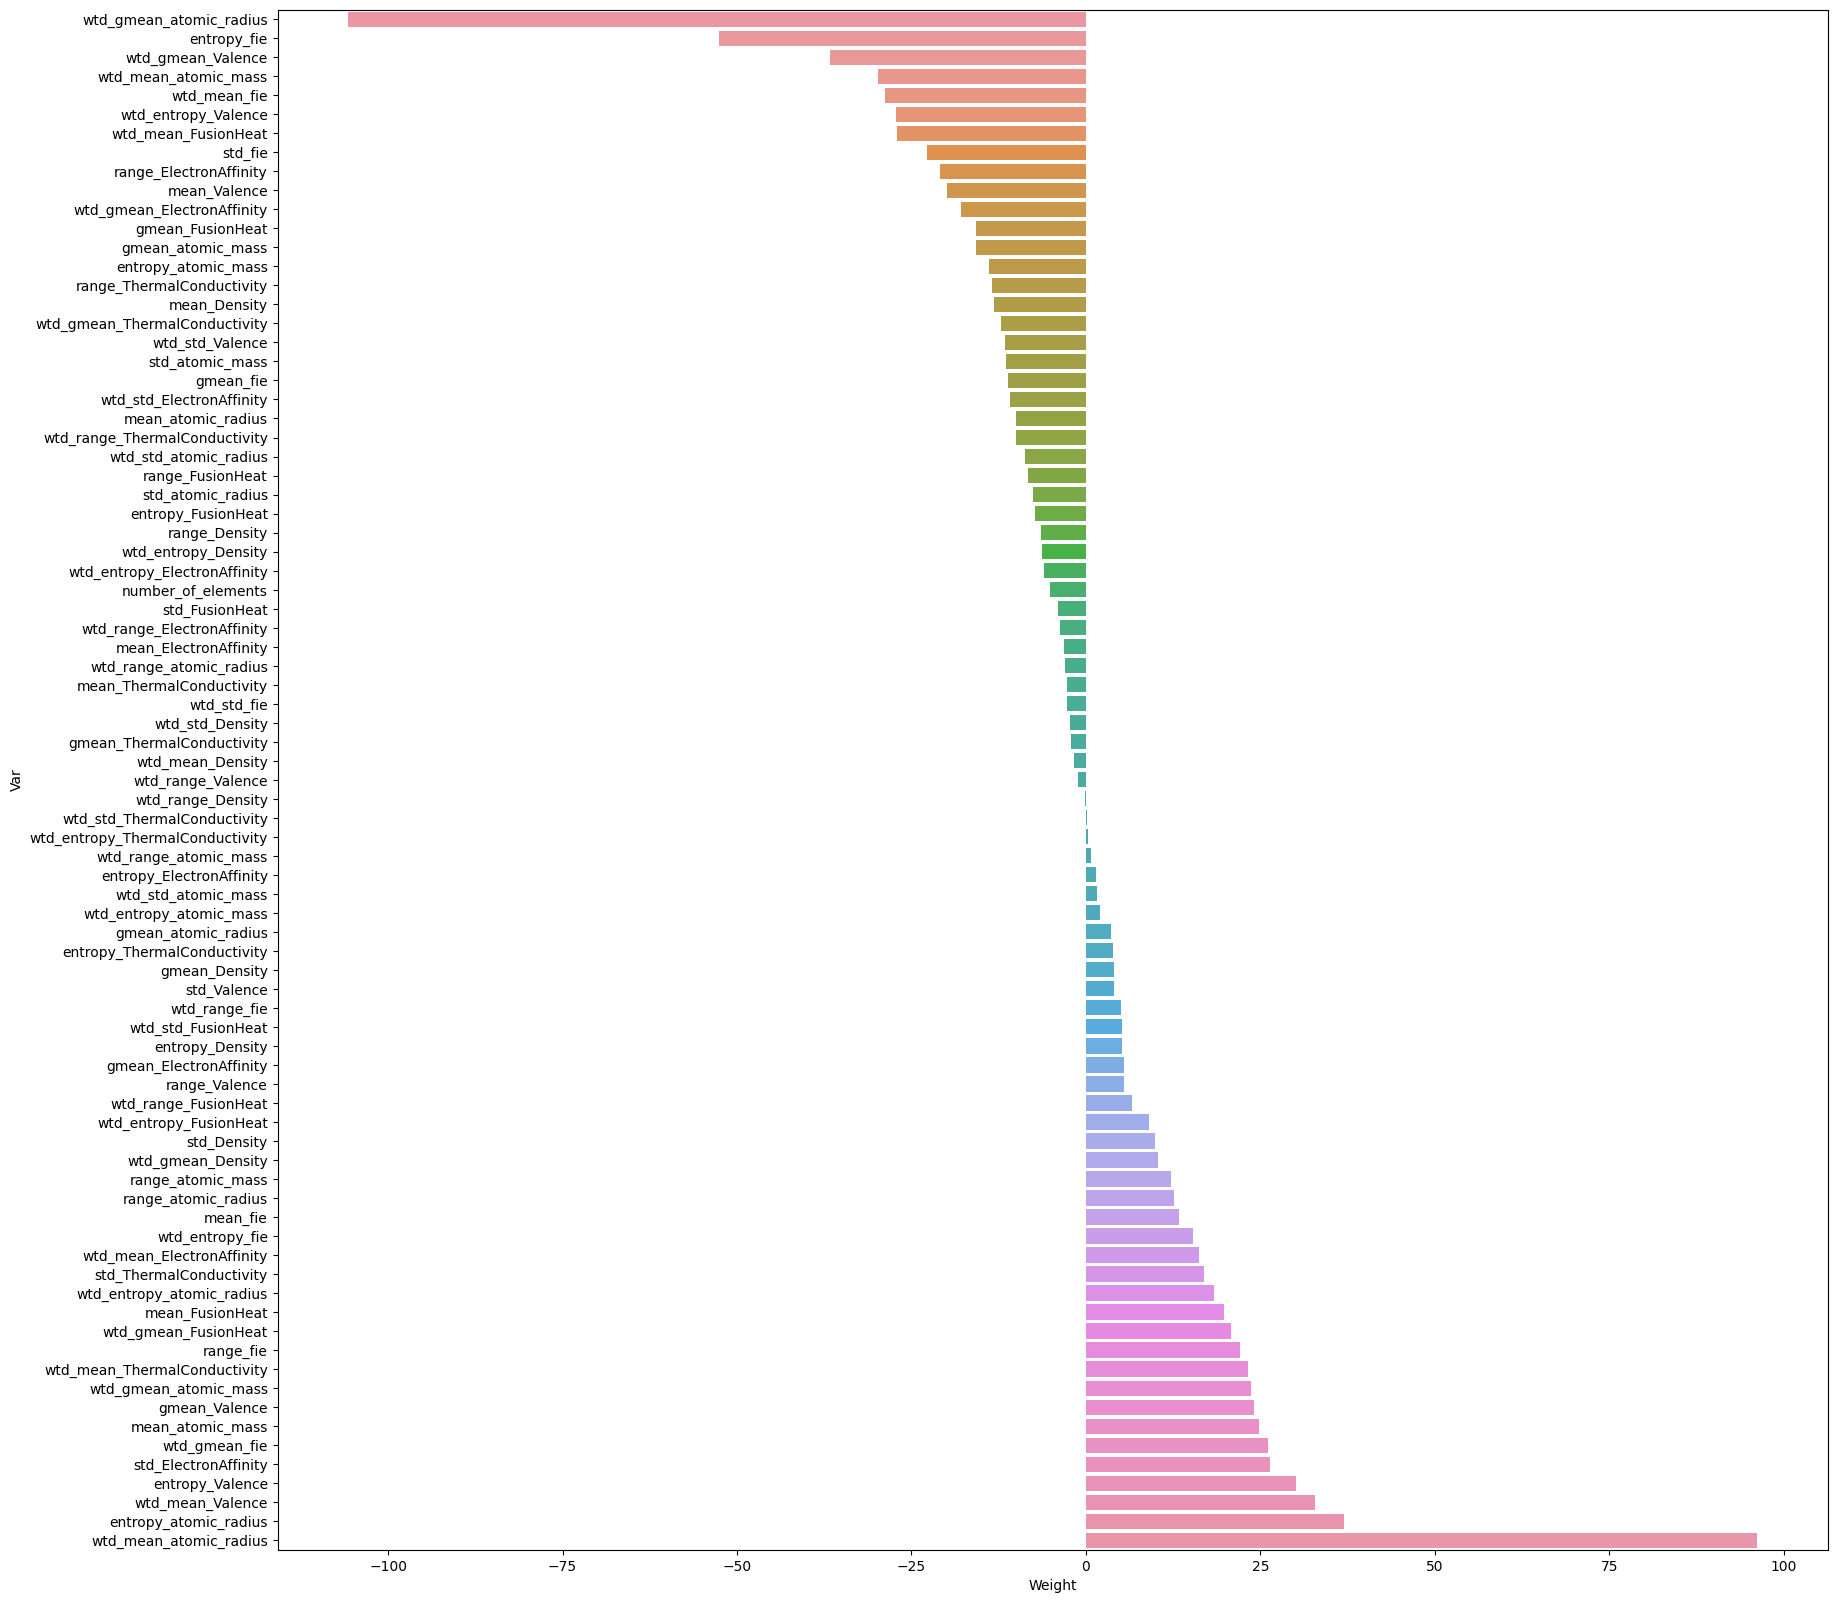

In [33]:
Weights = pd.Series(lin_reg.coef_[0], index = X_Scaled.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
plt.figure(figsize=(20, 20))
sns.barplot(x='Weight', y = 'Var', data = Weights);